In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import yfinance as yf

nvd = yf.download("NVDA", start='2024-04-08',end='2024-04-09', interval='1m')


amd = yf.download("AMD",start='2024-04-08',end='2024-04-09', interval='1m')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [2]:
p1 = nvd['Adj Close']
p2 = amd['Adj Close']

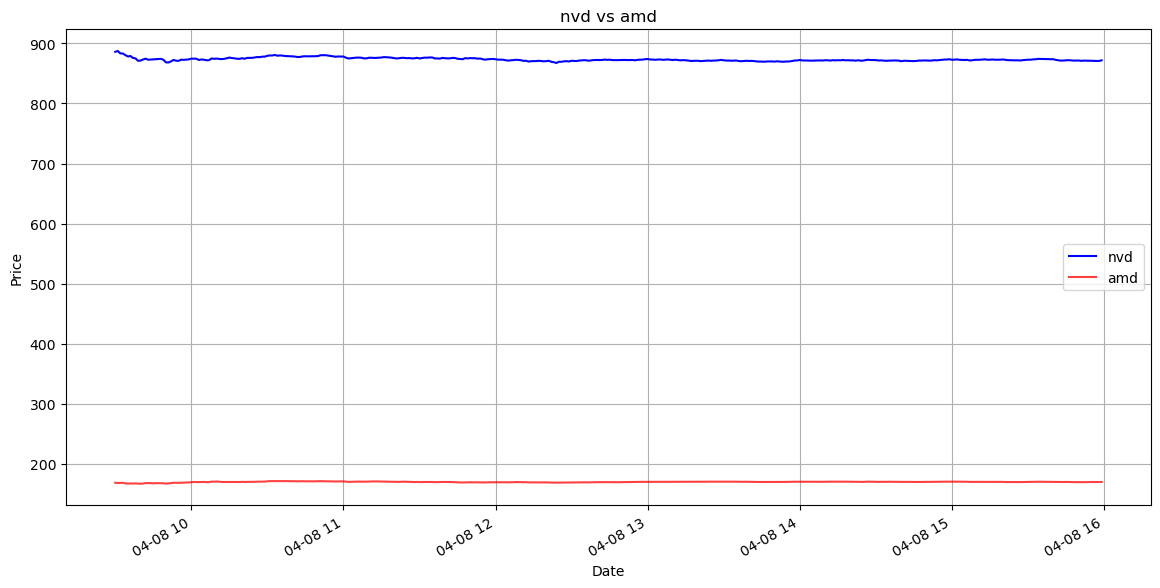

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
p1.plot(label='nvd', color='blue')
p2.plot(label='amd', color='red', alpha=0.75)
plt.title('nvd vs amd')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
from statsmodels.tsa.stattools import coint

# Test for cointegration
score, p_value, _ = coint(p1,p2)
print(f'Engle-Granger cointegration test p-value: {p_value}')

Engle-Granger cointegration test p-value: 0.0009285893909340454


In [8]:
S1_0 = nvd['Open'][0]
S2_0 = amd['Open'][0]
r1=np.log(nvd['Adj Close']/nvd['Adj Close'].shift(1))
r2=np.log(amd['Adj Close']/amd['Adj Close'].shift(1))

In [9]:
mu_1 = r1.mean()*390
mu_2 = r2.mean()*390
sigma_1 = r1.std()*np.sqrt(390)
sigma_2 = r2.std()*np.sqrt(390)
z_0 = 0

In [11]:
from scipy.stats import linregress
result=linregress(np.log(nvd['Adj Close']),np.log(amd['Adj Close']))
beta=result.slope

In [26]:
gamma = 0.5
delta=-1
rho=r1.corr(r2)
T=1
M=len(nvd['Adj Close'])

In [27]:
dt = T/M
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

Text(0.5, 1.0, 'z')

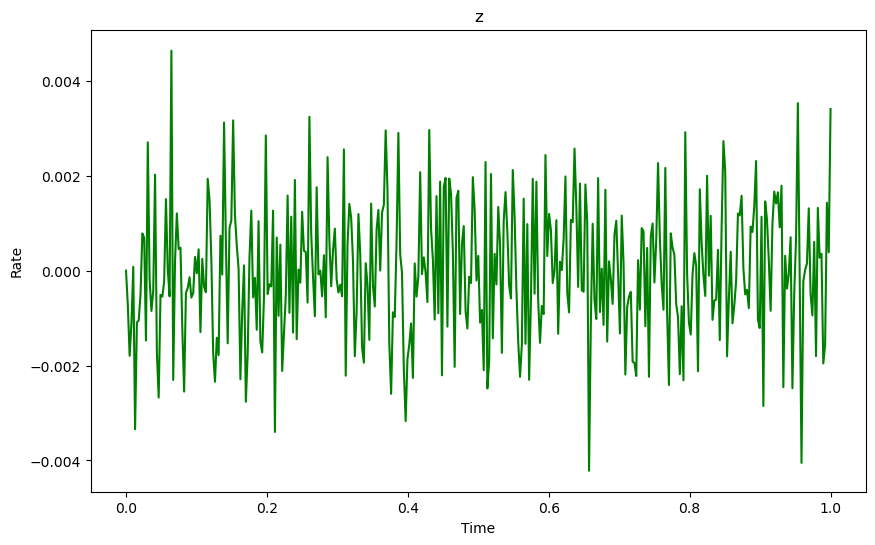

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(tt, z, 'g', lw=1.5)
plt.xlabel('Time')
plt.ylabel('Rate')
plt.title('z')

In [29]:
for t in range(1, M + 1):
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

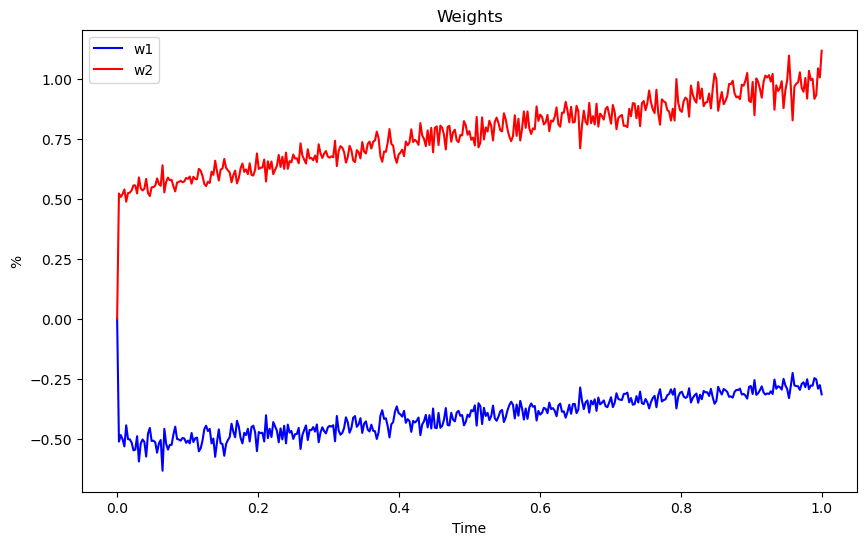

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='w1')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='w2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

Text(0.5, 1.0, 'Cash')

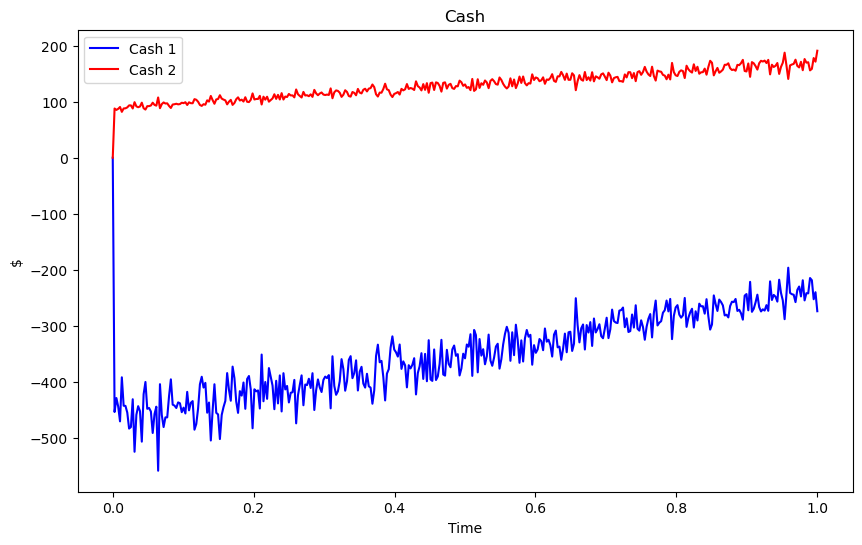

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1, 'b', lw=1.5, label='Cash 1')
plt.plot(tt, Pi_2 * S2, 'r', lw=1.5, label='Cash 2')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Cash')

Text(0.5, 1.0, 'Comparison')

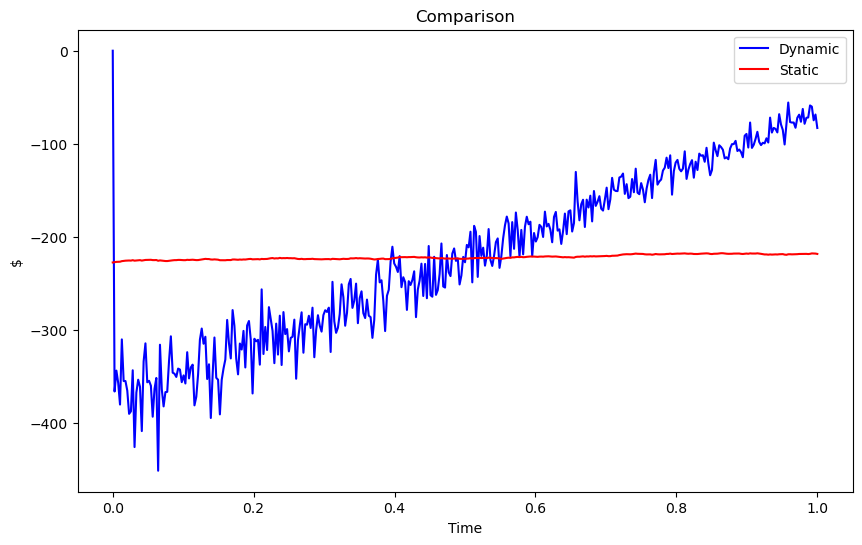

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1 * S1 + Pi_2 * S2, 'b', lw=1.5, label='Dynamic')
plt.plot(tt, Pi_1.mean() * S1 + Pi_2.mean() * S2, 'r', lw=1.5, label='Static')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('$')
plt.title('Comparison')